In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


from poclaps.train.ppo import reload

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

I0000 00:00:1731673297.638994  404332 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


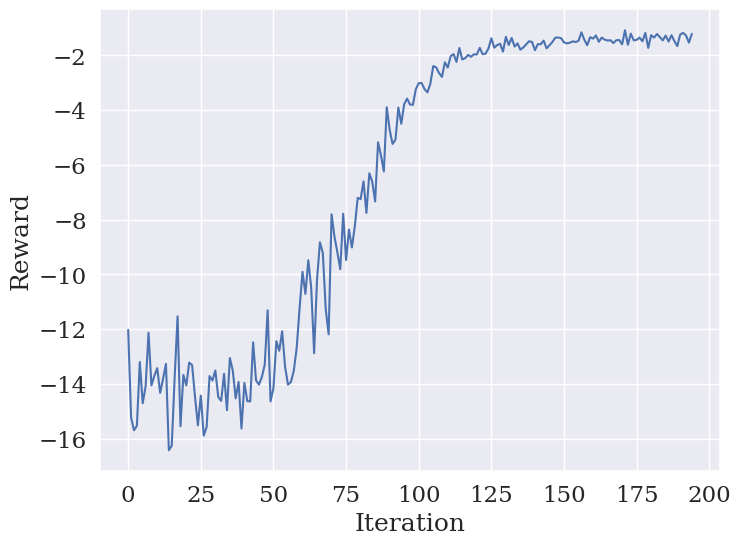

reformatted figures/policy_training_history/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [152]:
import pandas as pd
from reproducible_figures import save_reproducible_figure, set_plotting_style
import matplotlib.pyplot as plt


policy_training_metrics = pd.read_csv(f'{policy_dir}/metrics.csv')

def plot_policy_training_history(policy_training_metrics):
    set_plotting_style()
    _, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(policy_training_metrics['iteration'], policy_training_metrics['mean_reward'])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Reward')


save_reproducible_figure('policy_training_history', policy_training_metrics, plot_policy_training_history, show=True)

In [2]:
import jax
import numpy as np
from poclaps.rollout_fake_msgs import rollout_with_msgs


N_ACTIONS = env.action_space(env_params).n


def sample_obs_modelling_batch(rng,
                               noise_dim: int = 64,
                               rollout_steps: int = 500,
                               return_traj: bool = False):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, metrics = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng
    )

    n_msgs = env_params.grid_size * env_params.grid_size
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, n_msgs)

    *batch_shape, _ = traj_batch.obs.shape
    noise = jax.random.normal(rng, (*batch_shape, noise_dim))
    inputs = (actions, msgs, noise, traj_batch.obs, traj_batch.done)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [3]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)
actions, msgs, noise, obs, dones = inputs

In [4]:
T = 4
actions[:T, 0].argmax(-1), msgs[:T, 0].argmax(-1), dones[:T, 0], obs[:T, 0].reshape(-1, 2, 2, 5).argmax(-1)

(Array([1, 1, 4, 1], dtype=int32),
 Array([17, 17, 17, 17], dtype=int32),
 Array([False, False, False,  True], dtype=bool),
 Array([[[0, 4],
         [1, 1]],
 
        [[0, 3],
         [1, 1]],
 
        [[0, 2],
         [1, 1]],
 
        [[1, 2],
         [1, 1]]], dtype=int32))

In [36]:
from typing import Iterable
from poclaps.simple_gridworld_game import stringify_grid


def get_goals_and_pos(obs):
    """
    Args:
        obs: (T, n_envs, 20) shaped array of observations.
    Returns:
        goal_pos: (T, n_envs, 2) shaped array of goal positions.
        agent_pos: (T, n_envs, 2) shaped array of agent positions.
    """
    *batch_shape, _ = obs.shape
    env_states = obs.reshape((*batch_shape, 2, 2, 5)).argmax(-1)

    agent_pos = env_states[:, :, 0]
    goal_pos = env_states[:, :, 1]

    return goal_pos, agent_pos


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p): 'X', tuple(g): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))

goal_pos, agent_pos = get_goals_and_pos(obs[:T, 0])
print_episode(goal_pos.tolist(), agent_pos.tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| X |   |   |   | G |	| X |   |   | G |   |	| X |   | G |   |   |	|   | X | G |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [37]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=500)
actions, msgs, noise, obs, dones = inputs
obs.shape, actions.shape
start_obs, next_obs = obs[:-1], obs[1:]
actions = actions[:-1]

In [38]:
actions.shape, start_obs.shape, next_obs.shape

((499, 4, 5), (499, 4, 20), (499, 4, 20))

In [39]:
import flax.linen as nn
import jax.numpy as jnp
import functools


class TransitionModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, inputs):
        """
        Args:
            obs: (B, D)
            action: (B, A)
        """
        actions, obs = inputs
        x = jnp.concatenate([obs, actions], axis=-1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

transition_model = TransitionModel(start_obs.shape[-1])

inputs = (actions, start_obs)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)

pred_obs = transition_model.apply(init_params, inputs)
pred_obs.shape

(499, 4, 20)

In [40]:
from poclaps.train.losses import categorical_cross_entropy


def obs_loss_fn(act_obs, pred_obs_logits):
    n_steps, n_envs, obs_dim = act_obs.shape
    act_env_state = act_obs.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))
    pred_env_state = pred_obs_logits.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))

    # 1h vecs for actual positions
    act_agent_pos_x = act_env_state[:, :, 0, 0]
    act_agent_pos_y = act_env_state[:, :, 0, 1]
    act_goal_pos_x = act_env_state[:, :, 1, 0]
    act_goal_pos_y = act_env_state[:, :, 1, 1]

    # 1h vecs for predicted positions
    pred_agent_pos_x = pred_env_state[:, :, 0, 0]
    pred_agent_pos_y = pred_env_state[:, :, 0, 1]
    pred_goal_pos_x = pred_env_state[:, :, 1, 0]
    pred_goal_pos_y = pred_env_state[:, :, 1, 1]

    # CCE loss for positions
    cce_x = categorical_cross_entropy(pred_agent_pos_x, act_agent_pos_x)
    cce_y = categorical_cross_entropy(pred_agent_pos_y, act_agent_pos_y)
    cce_goal_x = categorical_cross_entropy(pred_goal_pos_x, act_goal_pos_x)
    cce_goal_y = categorical_cross_entropy(pred_goal_pos_y, act_goal_pos_y)

    return cce_x + cce_y + cce_goal_x + cce_goal_y

obs_loss_fn(act_obs=next_obs, pred_obs_logits=pred_obs)

Array([[6.3642464, 6.3394895, 6.6845865, 5.7896113],
       [6.874488 , 6.6926756, 7.018973 , 6.0660753],
       [6.318925 , 5.830632 , 7.281263 , 6.5533857],
       ...,
       [6.4623075, 6.8881254, 6.4147673, 6.6458693],
       [6.8159566, 6.392277 , 6.6540666, 6.2438498],
       [6.59458  , 6.508105 , 6.231048 , 6.2669954]], dtype=float32)

In [148]:
from flax.training.train_state import TrainState
import optax
import chex

N_ROLLOUT_STEPS = 500
N_TRAIN_STEPS = 300


def process_inps(batch):
    actions, msgs, noise, obs, dones = batch
    start_obs, next_obs = obs[:-1], obs[1:]
    actions = actions[:-1]
    dones_mask = 1.0 - dones[:-1]
    return (actions, start_obs), next_obs, dones_mask


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, batch):
        inputs, next_obs, dones_mask = process_inps(batch)
        next_obs_preds_logits = train_state.apply_fn(params, inputs)
        loss_vals = dones_mask * obs_loss_fn(next_obs, next_obs_preds_logits)
        return loss_vals.mean()

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)

rng, _rng = jax.random.split(rng)
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
*_, obs, _ = batch
transition_model = TransitionModel(obs.shape[-1])

inputs, *_ = process_inps(batch)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)
optimizer = optax.adam(1e-3)
transition_model_train_state = TrainState.create(
    apply_fn=transition_model.apply,
    params=init_params,
    tx=optimizer
)

(transition_model_train_state, _), metrics = jax.lax.scan(
    update_fn, (transition_model_train_state, rng), None, length=N_TRAIN_STEPS
)

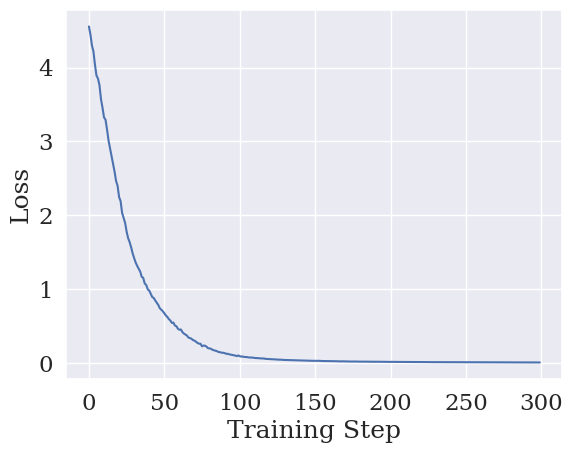

reformatted figures/transition_model_loss/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from reproducible_figures import save_reproducible_figure, set_plotting_style

def plot(df):
    set_plotting_style()
    ax = sns.lineplot(df, x='step', y='loss')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': np.arange(metrics['loss'].size)
})

save_reproducible_figure('transition_model_loss', df, plot, show=True)

In [43]:
TEST_STEPS = 500
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
inputs, next_obs, dones_mask = process_inps(batch)

In [44]:
next_obs.shape

(499, 4, 20)

In [45]:
next_goals_pos, next_agent_pos = get_goals_and_pos(next_obs)
next_goals_pos.shape, next_goals_pos[0]

((499, 4, 2),
 Array([[3, 3],
        [3, 2],
        [2, 4],
        [2, 4]], dtype=int32))

In [46]:
def logits_to_real_obs(logits, n_envs=4, temp=0.1):
    env_states = logits.reshape((-1, n_envs, 2, 2, 5))

    agent_pos_x = env_states[:, :, 0, 0]
    agent_pos_y = env_states[:, :, 0, 1]
    goal_pos_x = env_states[:, :, 1, 0]
    goal_pos_y = env_states[:, :, 1, 1]

    return jnp.concatenate(
        [
            jax.nn.softmax(agent_pos_x / temp),
            jax.nn.softmax(agent_pos_y / temp),
            jax.nn.softmax(goal_pos_x / temp),
            jax.nn.softmax(goal_pos_y / temp)
        ], axis=-1
    )

In [47]:
pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
pred_next_obs = logits_to_real_obs(pred_next_obs_logits)

In [48]:
precision = 5
n_correct = (dones_mask * (next_obs == pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [49]:
pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
# pred_next_obs = logits_to_real_obs(pred_next_obs_logits)[0].round()
pi, *_ = pretrained_policy(obs)
pred_act = pi.sample(seed=jax.random.PRNGKey(0))
inputs = (jax.nn.one_hot(pred_act, 5), pred_next_obs)

In [50]:
inputs[0][0]

Array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [51]:
def compute_compounding_obs_preds(obs, inps, temp=0.1):
    act_next_obs, dones_mask, actions = inps
    # pi, *_ = pretrained_policy(obs)
    # pred_act = pi.sample(seed=jax.random.PRNGKey(0))
    # inputs = (jax.nn.one_hot(pred_act, 5), pred_obs)
    inputs = (actions, obs)
    pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
    pred_next_obs = logits_to_real_obs(pred_next_obs_logits, temp=temp)[0]

    next_obs = jnp.where(
        (dones_mask == 0)[:, None], act_next_obs, pred_next_obs
    )

    return next_obs, pred_next_obs

batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
(action, obs), next_obs, dones_mask = process_inps(batch)

In [52]:
_, compounded_pred_next_obs = jax.lax.scan(
    compute_compounding_obs_preds, obs[0], (next_obs, dones_mask, action)
)

precision = 5
n_correct = (dones_mask * (next_obs == compounded_pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [53]:
T = 4
ENV_IDX = 1
print(dones_mask[:T, ENV_IDX])
goal_pos, agent_pos = get_goals_and_pos(pred_next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

[1. 1. 0. 1.]
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G | X |	|   |   |   | G |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [54]:
T = 4
goal_pos, agent_pos = get_goals_and_pos(next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   |   |   |	|   |   |   |   | G |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G | X |	|   | X |   |   |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [55]:
def actions_preds_loss(obs_preds, true_actions):
    pred_action_dist, _ = pretrained_policy(obs_preds)
    return categorical_cross_entropy(
        pred_action_dist.logits, true_actions
    ).mean()


actions_preds_loss(compounded_pred_next_obs, action)

Array(1.6535125, dtype=float32)

In [56]:
def actions_preds_acc(obs_preds, true_actions):
    pred_action_dist, _ = pretrained_policy(obs_preds)
    pred_actions = pred_action_dist.logits.argmax(-1)
    return (pred_actions == true_actions.argmax(-1)).mean()


actions_preds_acc(compounded_pred_next_obs, action)

Array(0.41883767, dtype=float32)

In [57]:
import jax


def sample_init_obs_batch(rng,
                          noise_dim: int = 64,
                          batch_size: int = 512):
    noise_rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, batch_size)
    init_obs, _ = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)
    noise = jax.random.normal(noise_rng, (batch_size, noise_dim))
    return noise, init_obs

In [58]:
sample_init_obs_batch(jax.random.PRNGKey(0), batch_size=2)

(Array([[-0.09888369,  2.506235  ,  0.7709646 , -2.566372  , -1.056678  ,
         -0.08589505, -1.1263483 , -1.4746587 ,  1.0176736 , -0.08870202,
         -2.2064896 , -1.8556206 , -0.42565253, -1.2255049 , -1.0866312 ,
          1.1943948 ,  0.40512082, -1.7767317 ,  1.7513275 ,  1.5189085 ,
          0.87630486,  0.39879364,  0.6973779 ,  0.12441269,  0.5953105 ,
          1.0668632 , -0.2580644 , -0.5771248 ,  0.9866648 ,  1.110345  ,
         -0.6736215 , -0.9863035 ,  0.14894868, -1.08898   , -0.03916076,
         -0.6194477 ,  0.3279911 ,  0.5261584 ,  1.226813  ,  1.2293104 ,
          1.6715007 , -0.58628327,  1.7278807 ,  0.32560784,  0.75145096,
         -0.970783  ,  0.15815397,  0.52384853, -0.6927399 ,  1.363632  ,
          1.0026302 ,  0.9920616 , -0.09005146,  1.4980816 ,  0.0134411 ,
         -0.17539886,  1.4234868 , -0.90153   ,  0.5668088 , -0.35222855,
          0.03952095,  1.1127486 , -0.0499901 , -2.106966  ],
        [ 0.14152686,  0.8560746 , -0.6304051 , -0

In [59]:
class InitObsModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, noise):
        """
        Args:
            noise: (B, D)
        """
        x = nn.Dense(self.hidden_dim)(noise)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

In [123]:
# from flax.training.train_state import TrainState
# import optax
# import chex

# BATCH_SIZE = 512
# N_TRAIN_STEPS = 300


# @jax.jit
# def update_fn(state: tuple, _):
#     train_state, rng = state

#     def compute_loss(params, batch):
#         noise, obs = batch
#         obs_preds_logits = train_state.apply_fn(params, noise)
#         obs = obs.reshape((BATCH_SIZE, 1, -1))
#         obs_preds_logits = obs_preds_logits.reshape((BATCH_SIZE, 1, -1))
#         loss_vals = obs_loss_fn(obs, obs_preds_logits)
#         return loss_vals.mean()

#     rng, _rng = jax.random.split(rng)
#     batch = sample_init_obs_batch(_rng, batch_size=BATCH_SIZE)
#     loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
#     new_train_state = train_state.apply_gradients(grads=grads)
#     metrics = {'loss': loss}
#     return (new_train_state, rng), metrics


# rng = jax.random.PRNGKey(0)

# rng, _rng = jax.random.split(rng)
# noise, obs = sample_init_obs_batch(_rng, batch_size=BATCH_SIZE)
# init_obs_model = InitObsModel(obs.shape[-1])
# rng, _rng = jax.random.split(rng)
# init_params = init_obs_model.init(_rng, noise)
# optimizer = optax.adam(1e-3)
# init_obs_train_state = TrainState.create(
#     apply_fn=init_obs_model.apply,
#     params=init_params,
#     tx=optimizer
# )

# (init_obs_train_state, _), metrics = jax.lax.scan(
#     update_fn, (init_obs_train_state, rng), None, length=N_TRAIN_STEPS
# )

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# sns.set_theme()

# df = pd.DataFrame({
#     'loss': metrics['loss'],
#     'step': np.arange(metrics['loss'].size)
# })

# sns.lineplot(df, x='step', y='loss')
# plt.show()

In [124]:
# rng = jax.random.PRNGKey(0)
# rng, _rng = jax.random.split(rng)
# noise, _ = sample_init_obs_batch(_rng, batch_size=5)
# init_obs_pred = init_obs_model.apply(init_obs_train_state.params, noise)

In [125]:
# init_obs_pred.round(2)

In [153]:
def create_rollout_state_with_fixed_goal_pos(rng, n_seqs):
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    rng, _rng = jax.random.split(rng)
    set_goal_pos = jax.random.randint(_rng, (2,), 0, env.grid_size)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(set_goal_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    return (env_state, obsv, rng, ep_ids)


def sample_sequences(rng,
                     n_seqs=64,
                     seq_len=8,
                     comm_policy_seed=0,
                     rollout_state=None,
                     fix_goal_pos_in_batch: bool = False):
    """
    Returns:
        (actions_1h, msgs_1h, seq_mask): 1h vectors for actions and messages,
            and a mask for sequences.
        obs: (T, n_envs, 20) shaped array of observations.
    """

    rng, rollout_rng = jax.random.split(rng)

    if fix_goal_pos_in_batch and rollout_state is None:
        rollout_rng, _rng = jax.random.split(rollout_rng)
        rollout_state = create_rollout_state_with_fixed_goal_pos(_rng, n_seqs)
    elif rollout_state is None:
        rollout_state = None

    _, traj_batch, _ = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=seq_len,
        n_envs=n_seqs,
        rng=rollout_rng,
        comm_policy_seed=comm_policy_seed,
        rollout_state=rollout_state
    )

    def compute_seq_mask(done_carry, done_t):
        # when done_t is True, the sequence is finished
        # but we want to include this in the sequence
        # so we set the mask to False on the last step,
        # we we can detect because done_carry is still false
        not_carry = jnp.logical_not(done_carry)
        is_last = jnp.logical_and(done_t, not_carry)
        is_part_of_seq = jnp.logical_or(is_last, not_carry)
        mask_val = jnp.logical_not(is_part_of_seq)
        done_carry = jnp.logical_or(done_carry, done_t)
        return done_carry, mask_val

    done_carry = jnp.zeros((n_seqs,), dtype=bool)
    _, seq_mask = jax.lax.scan(
        compute_seq_mask, done_carry, traj_batch.done
    )
    # True = sequence finished, False = sequence not finished
    too_short = jnp.repeat((seq_mask.argmax(0) < 2)[np.newaxis, ...], seq_len, axis=0)
    # sequences that are too short should not be used
    seq_mask = jnp.logical_or(too_short, seq_mask)

    n_msgs = env_params.grid_size * env_params.grid_size
    actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs_1h = jax.nn.one_hot(traj_batch.message, n_msgs)

    return (actions_1h, msgs_1h, rng, seq_mask), traj_batch

In [61]:
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools


class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, rnn_state, x):
        """Applies the module."""
        ins, seq_mask = x
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        new_rnn_state = jnp.where(
            seq_mask[:, np.newaxis],
            rnn_state,
            new_rnn_state,
        )
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


class ActionsMsgsEncoder(nn.Module):
    enc_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        actions, msgs, rng, seq_mask = inputs
        feats = jnp.concatenate([actions, msgs], axis=-1)

        x = nn.Dense(self.hidden_size)(feats)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        _, n_envs, _ = x.shape
        carry = ScannedRNN.initialize_carry(n_envs, self.hidden_size)
        action_enc, _ = ScannedRNN(self.hidden_size)(carry, (x, seq_mask))

        return nn.Dense(self.enc_size)(action_enc)

In [62]:
from tensorflow_probability.substrates import jax as tfp


def relaxed_sample_real_obs(logits, rng, temp=0.1):
    n_envs, *_ = logits.shape
    env_states_logits = logits.reshape((n_envs, 2, 2, 5))

    agent_pos_x_logits = env_states_logits[:, 0, 0]
    agent_pos_y_logits = env_states_logits[:, 0, 1]
    goal_pos_x_logits = env_states_logits[:, 1, 0]
    goal_pos_y_logits = env_states_logits[:, 1, 1]

    agent_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_x = agent_x_dist.sample(seed=_rng)

    agent_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_y = agent_y_dist.sample(seed=_rng)

    goal_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_x = goal_x_dist.sample(seed=_rng)

    goal_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_y = goal_y_dist.sample(seed=_rng)

    return jnp.concatenate(
        [agent_pos_x, agent_pos_y, goal_pos_x, goal_pos_y],
        axis=-1
    )


class ObsActionDecoder(nn.Module):
    obs_dim: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs, temp: float = 0.1):
        actions, msgs, rng, seq_mask = inputs
        seq_len, n_seqs = seq_mask.shape

        action_msgs_enc = ActionsMsgsEncoder(self.hidden_size)(inputs)
        init_obs_logits = InitObsModel(self.obs_dim)(action_msgs_enc)
        rng, _rng = jax.random.split(rng)
        init_obs = relaxed_sample_real_obs(
            init_obs_logits, _rng, temp=temp
        )

        def simulate_rollout_step(obs, step_rng):
            """
            Uses the pretrained policy and transition function to simulate
            a step of a rollout from the given observation.
            """
            action_rng, obs_rng = jax.random.split(step_rng)
            pi, *_ = pretrained_policy(obs)
            action_logits = pi.logits
            action_dist = tfp.distributions.RelaxedOneHotCategorical(
                temp, logits=action_logits
            )
            action_probs = action_dist.sample(seed=action_rng)
            # action_probs = jax.nn.softmax(action_logits / temp)
            transition_inp = (action_probs, obs)
            next_obs_logits = transition_model.apply(
                transition_model_train_state.params,
                transition_inp
            )
            next_obs = relaxed_sample_real_obs(
                next_obs_logits, obs_rng, temp=temp
            )
            return next_obs, (next_obs, action_logits)

        step_rngs = jax.random.split(rng, seq_len)
        _, (obs_preds, action_logits) = jax.lax.scan(
            simulate_rollout_step, init_obs, step_rngs
        )

        # include the initial observation in the predictions and remove
        # the last prediction to match the shape of the input observations
        obs_preds = jnp.concatenate([init_obs[None], obs_preds[:-1]], axis=0)

        return obs_preds, action_logits

In [63]:
inputs, traj_batch = sample_sequences(jax.random.PRNGKey(0), n_seqs=2, seq_len=8)
obs_action_decoder = ObsActionDecoder(traj_batch.obs.shape[-1], 64)

init_params = obs_action_decoder.init(jax.random.PRNGKey(0), inputs)

obs_preds, action_pred_logits = obs_action_decoder.apply(init_params, inputs)

true_actions, messages, rng, seq_mask = inputs

In [64]:
traj_batch.obs.shape, obs_preds.shape, action_pred_logits.shape, true_actions.shape

((8, 2, 20), (8, 2, 20), (8, 2, 5), (8, 2, 5))

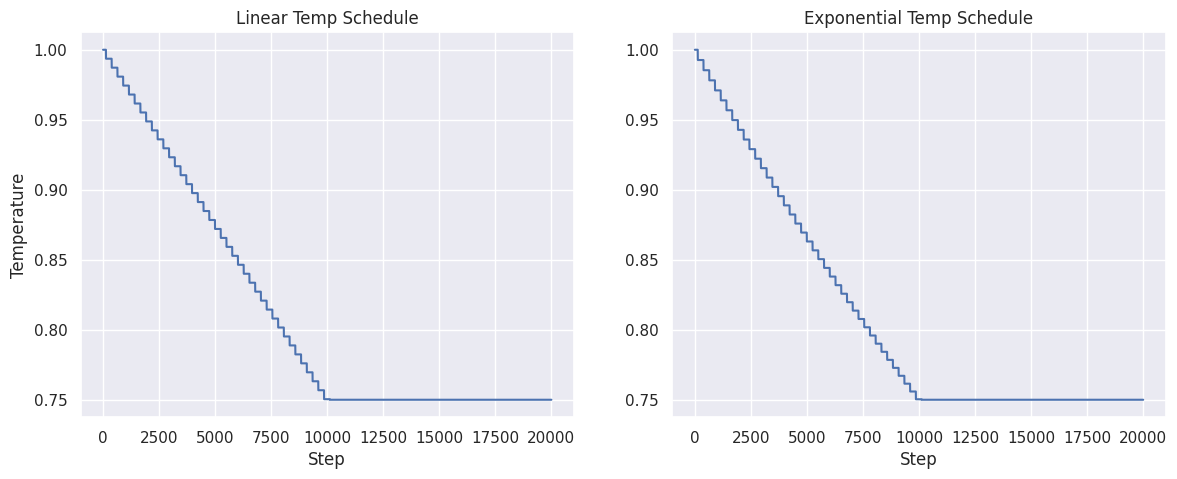

In [65]:
BATCH_SIZE = 512
SEQ_LEN = 8
N_TRAIN_STEPS = 20000

HIGH_TEMP = 1.0
LOW_TEMP = 0.75
ROUND_FAC = 256
SCHEDULE_STEPS = 10000
FIX_GOAL_IN_BATCH = True


def linear_temp_schedule(step,
                         high_t = HIGH_TEMP,
                         low_t = LOW_TEMP,
                         schedule_steps = SCHEDULE_STEPS,
                         round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    return jnp.clip(high_t - (high_t - low_t) * (step / schedule_steps), low_t)


def exponential_temp_schedule(step,
                              high_t = HIGH_TEMP,
                              low_t = LOW_TEMP,
                              schedule_steps = SCHEDULE_STEPS,
                              round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    decay_fac = jnp.log(low_t / high_t) / schedule_steps
    temp = high_t * jnp.exp(decay_fac * step)
    return jnp.clip(temp, low_t, high_t)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(np.arange(N_TRAIN_STEPS), linear_temp_schedule(np.arange(N_TRAIN_STEPS)))
axs[0].set_title('Linear Temp Schedule')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Temperature')
axs[1].plot(np.arange(N_TRAIN_STEPS), exponential_temp_schedule(np.arange(N_TRAIN_STEPS)))
axs[1].set_title('Exponential Temp Schedule')
axs[1].set_xlabel('Step')
plt.show()


In [66]:
from flax.training.train_state import TrainState
import optax


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    # temp = exponential_temp_schedule(train_state.step)
    temp = 1.0

    def compute_loss(params, batch):
        _, action_pred_logits = train_state.apply_fn(params, batch, temp=temp)
        true_actions, _, _, seq_mask = batch
        loss_vals = (1.0 - seq_mask) * categorical_cross_entropy(
            action_pred_logits, true_actions
        )
        return loss_vals.mean()

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_sequences(
        _rng,
        n_seqs=BATCH_SIZE,
        seq_len=SEQ_LEN,
        fix_goal_pos_in_batch=FIX_GOAL_IN_BATCH
    )
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'step': train_state.step, 'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=SEQ_LEN)
obs_action_decoder = ObsActionDecoder(traj_batch.obs.shape[-1], 64)
init_params = obs_action_decoder.init(jax.random.PRNGKey(0), inputs)

optimizer = optax.adam(1e-4)
obs_action_decoder_train_state = TrainState.create(
    apply_fn=obs_action_decoder.apply,
    params=init_params,
    tx=optimizer
)

(obs_action_decoder_train_state, _), metrics = jax.lax.scan(
    update_fn, (obs_action_decoder_train_state, rng), None, length=N_TRAIN_STEPS
)

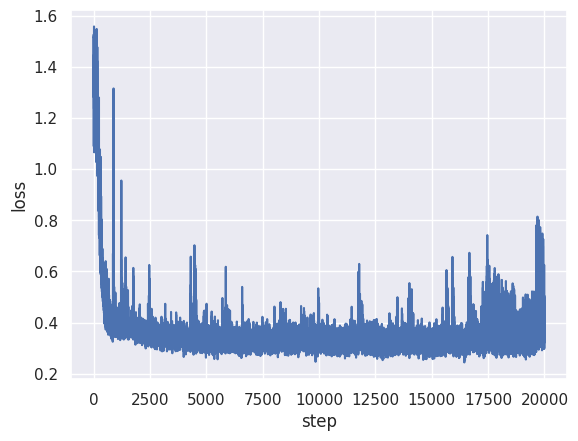

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': metrics['step']
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [95]:
rng = jax.random.PRNGKey(1)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=SEQ_LEN, fix_goal_pos_in_batch=True)
obs_preds, action_pred_logits = obs_action_decoder.apply(obs_action_decoder_train_state.params, inputs, temp=0.1)

In [96]:
actions, messages, _, seq_mask = inputs
i = 9
ep_len = seq_mask[:, i].argmax()
print('Sequence Mask:', seq_mask[:, i], "(True = Not In Sequence)")
print('Dones:', traj_batch.done[:, i])
print('Episode Length:', ep_len)
print('True Actions:', actions[:, i].argmax(-1)[:ep_len])
print('Predicted Actions:', action_pred_logits[:, i].argmax(-1)[:ep_len])

print('Predicted Epsiode:')
predicted_ep = obs_preds[:, i].round(2)[:ep_len]
goal_pos, agent_pos = get_goals_and_pos(predicted_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

print('Actual Episode:')
actual_ep = traj_batch.obs[:, i].round(2)[:seq_mask[:, i].argmax()]
goal_pos, agent_pos = get_goals_and_pos(actual_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

Sequence Mask: [False False False False False False  True  True] (True = Not In Sequence)
Dones: [False False False False False  True  True False]
Episode Length: 6
True Actions: [3 1 3 1 1 3]
Predicted Actions: [3 3 3 3 1 3]
Predicted Epsiode:
---------------------	---------------------	---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------	---------------------	---------------------
|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |	|   | G |   |   |   |
---------------------	---------------------	---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   | X |   |	|   |   | X |   |   |	|   | X

In [97]:
predicted_ep = obs_preds.round(2)
pred_goal_pos, _ = get_goals_and_pos(predicted_ep)

delta_goal_pos = jnp.abs(pred_goal_pos - traj_batch.env_state.env_state.goal_pos)
goal_pos_dist = jnp.linalg.norm(delta_goal_pos, ord=1, axis=-1)
goal_pos_dist_mean = goal_pos_dist[jnp.logical_not(seq_mask)].mean()
goal_pos_dist_std = goal_pos_dist[jnp.logical_not(seq_mask)].std()
goal_pos_dist_mean.item(), goal_pos_dist_std.item()

(0.880740225315094, 1.4494566917419434)

In [98]:
from poclaps.rollout_fake_msgs import SimpleGridWorldCommPolicy

COMM_POLICY_SEED = 0

predicted_ep = obs_preds.round(2)
goal_pos, _ = get_goals_and_pos(predicted_ep)
*batch_shape, _ = goal_pos.shape
goal_pos = goal_pos.reshape((np.prod(batch_shape), 2))

comm_policy = SimpleGridWorldCommPolicy(COMM_POLICY_SEED, env_params)

pred_msgs = jax.lax.map(
    lambda g: comm_policy.get_msg(g),
    goal_pos
)
pred_msgs = pred_msgs.reshape(batch_shape)
(pred_msgs == traj_batch.message)[jnp.logical_not(seq_mask)].mean()

Array(0.9150103, dtype=float32)

In [101]:
traj_batch.message[0, 0].item()

17

In [106]:
# from tdqm import tqdm

items = []

N_SEEDS = 100

# progress = tqdm(total=N_SEEDS)

for seed in range(N_SEEDS):
    rng = jax.random.PRNGKey(seed)
    rng, _rng = jax.random.split(rng)
    inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=SEQ_LEN, fix_goal_pos_in_batch=True)
    obs_preds, action_pred_logits = obs_action_decoder.apply(
        obs_action_decoder_train_state.params, inputs, temp=0.1
    )

    predicted_ep = obs_preds.round(2)
    goal_pos, _ = get_goals_and_pos(predicted_ep)
    *batch_shape, _ = goal_pos.shape
    goal_pos = goal_pos.reshape((np.prod(batch_shape), 2))

    pred_msgs = jax.lax.map(
        lambda g: comm_policy.get_msg(g),
        goal_pos
    )
    pred_msgs = pred_msgs.reshape(batch_shape)
    msg_acc = (pred_msgs == traj_batch.message)[jnp.logical_not(seq_mask)].mean()
    msg = traj_batch.message[0, 0].item()

    items.append({'Message': msg, 'Accuracy': msg_acc})

    # progress.update()
    if seed % 10 == 0:
        print(f'Seed {seed}: {msg_acc}')


msg_acc_df = pd.DataFrame(items)

Seed 0: 0.38793694972991943
Seed 10: 0.010281014256179333
Seed 20: 0.6394791007041931
Seed 30: 0.38930773735046387
Seed 40: 0.00891021266579628
Seed 50: 0.01507882121950388
Seed 60: 0.010966415517032146
Seed 70: 0.013022618368268013
Seed 80: 0.004797806963324547
Seed 90: 0.017135024070739746


In [115]:
msg_acc_df.head()

,Message,Accuracy,Goal X,Goal Y
0,4,0.38793695,0,4
1,17,0.9150103,3,2
2,12,0.008224811,2,2
3,3,0.010281014,0,3
4,16,0.008224811,3,1


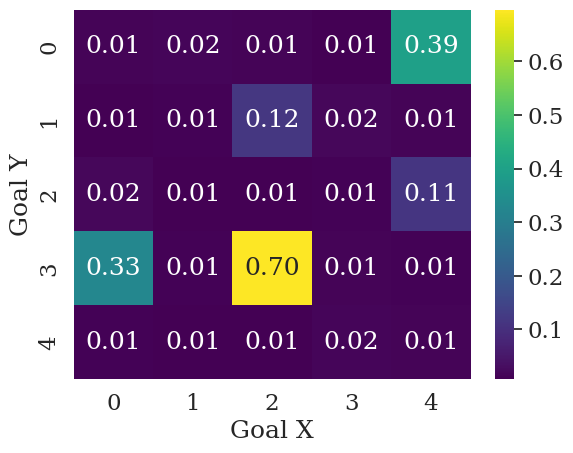

reformatted figures/goal_pos_acc_table/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [132]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_acc_table(msg_acc_df):
    msg_acc_df['Goal X'] = msg_acc_df['Message'] // env_params.grid_size
    msg_acc_df['Goal Y'] = msg_acc_df['Message'] % env_params.grid_size

    acc_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].mean().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(acc_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True, fmt='.2f'
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


save_reproducible_figure(
    'goal_pos_acc_table',
    msg_acc_df,
    plot_acc_table,
    show=True
)

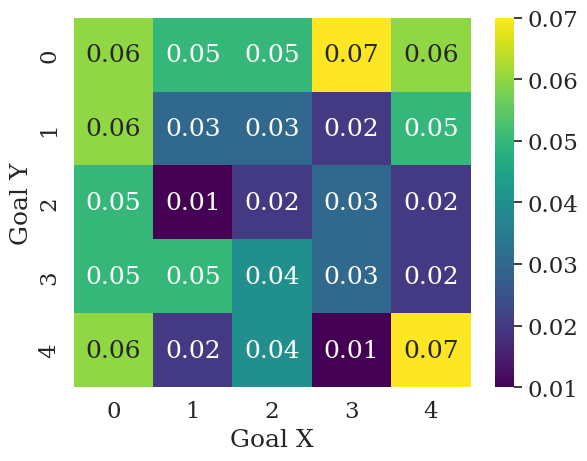

reformatted figures/goal_pos_count_table/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [146]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_count_table(msg_acc_df):
    msg_acc_df['Goal X'] = msg_acc_df['Message'] // env_params.grid_size
    msg_acc_df['Goal Y'] = msg_acc_df['Message'] % env_params.grid_size

    count_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].count().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')
    count_table = count_table / count_table.sum().sum()

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(count_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


save_reproducible_figure(
    'goal_pos_count_table',
    msg_acc_df,
    plot_count_table,
    show=True
)

In [ ]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_acc_table(msg_acc_df):
    msg_acc_df['Goal X'] = msg_acc_df['Message'] // env_params.grid_size
    msg_acc_df['Goal Y'] = msg_acc_df['Message'] % env_params.grid_size

    acc_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].mean().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(acc_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True, fmt='.2f'
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


save_reproducible_figure(
    'goal_pos_acc_table',
    msg_acc_df,
    plot_acc_table,
    show=True
)

In [154]:
def create_rollout_state(n_seqs, goal_pos, agent_pos, seed=0):
    reset_rng = jax.random.split(jax.random.PRNGKey(0), n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(goal_pos[None], n_seqs, axis=0),
            agent_pos=jnp.repeat(agent_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    rng = jax.random.PRNGKey(seed)
    return (env_state, obsv, rng, ep_ids)

In [175]:
agent_pos = jnp.array([0, 0])
goal_pos = jnp.array([env_params.grid_size - 1, env_params.grid_size - 1])

samples = 512
rollout_state = create_rollout_state(samples, goal_pos, agent_pos)

inputs, traj_batch = sample_sequences(
    jax.random.PRNGKey(0),
    n_seqs=samples,
    seq_len=10,
    rollout_state=rollout_state
)

In [ ]:
traj_batch.env_state.env_state.agent_pos[:, 0]

Array([[1, 0],
       [1, 1],
       [1, 2],
       [2, 2],
       [3, 2],
       [3, 3],
       [4, 3],
       [2, 3],
       [1, 3],
       [1, 2]], dtype=int32)

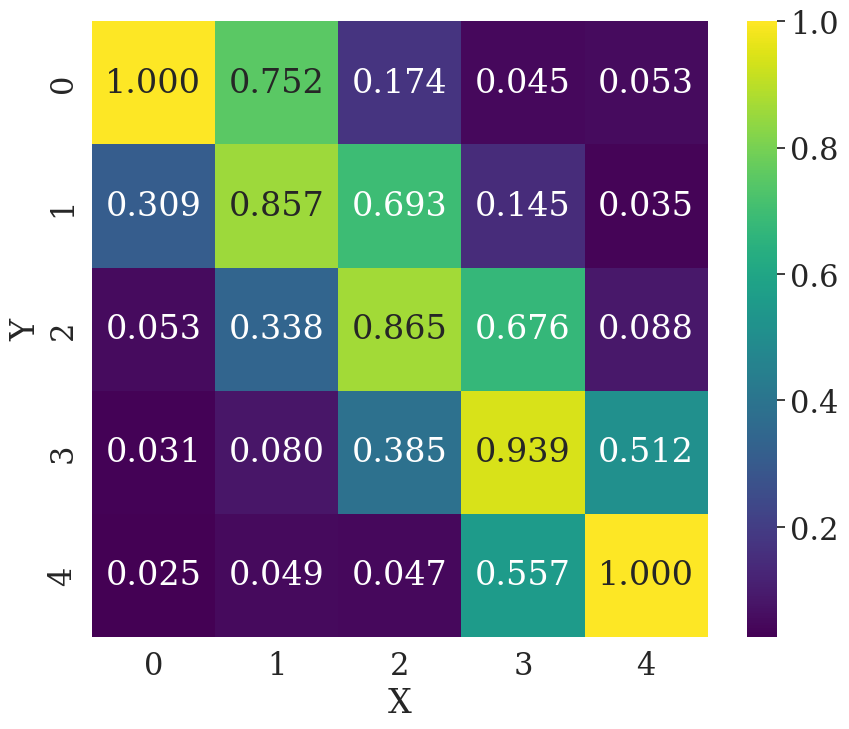

reformatted figures/prelim_run_results/agent_pos_heatmap/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [205]:
agent_pos = traj_batch.env_state.env_state.agent_pos
seq_len, n_seqs, _ = agent_pos.shape

# agent_pos = agent_pos.reshape((seq_len * n_seqs, 2))
*_, seq_mask = inputs
agent_pos = agent_pos[jnp.logical_not(seq_mask)]


agent_pos_df = pd.DataFrame(agent_pos, columns=['X', 'Y'])

def plot_policy_location_heatmap(agent_pos_df, grid_size, n_samples):
    agent_pos_df['idx'] = agent_pos_df['X'] * grid_size + agent_pos_df['Y']
    location_heatmap = agent_pos_df.groupby(['X', 'Y'])['idx'].count().reset_index().pivot(index='X', columns='Y', values='idx')
    location_heatmap[grid_size - 1][grid_size - 1] = n_samples
    location_heatmap[0][0] = n_samples

    set_plotting_style(font_scale=2)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        location_heatmap.T / n_samples,
        cmap='viridis', cbar=True,
        annot=True, fmt='.3f',
        square=True
    )


save_reproducible_figure(
    'agent_pos_heatmap',
    agent_pos_df,
    plot_policy_location_heatmap,
    show=True,
    figures_dir='figures/prelim_run_results',
    grid_size=env_params.grid_size,
    n_samples=samples
)